In [1]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip ./data.zip

--2021-07-10 20:00:20--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.164.117, 13.35.164.26, 13.35.164.89, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.164.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  2.23MB/s    in 1.2s    

2021-07-10 20:00:22 (2.23 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  ./data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/It

In [2]:
import sys
sys.path.append('../input/char-rnn-classification')

In [3]:
from __future__ import unicode_literals, print_function, division
import torch
from torch import nn
from torch import optim
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from model import RNN
from utils import * 

N_ITERS = 100000
PRINT_EVERY = 5000
PLOT_EVERY = 1000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_HIDDEN = 128
N_CATEGORIES = None


def train_one_epoch(rnn, category_tensor, line_tensor, criterion, optimizer):
    hidden = rnn.init_hidden()
    hidden = hidden.to(DEVICE)
    optimizer.zero_grad()

    for i in range(line_tensor.shape[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

def train(rnn, categories, category_lines, all_losses):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(rnn.parameters(), lr=0.0001)

    start = time.time()

    # Keep track of losses for plotting
    current_loss = 0

    for iter in range(1, N_ITERS + 1):
        category, line, category_tensor, line_tensor = random_training_example(categories, category_lines)
        category_tensor = category_tensor.to(DEVICE)
        line_tensor = line_tensor.to(DEVICE)
        output, loss = train_one_epoch(rnn, category_tensor, line_tensor, criterion, optimizer)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % PRINT_EVERY == 0:
            guess, guess_i = category_from_output(output, categories)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / N_ITERS * 100, time_since(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % PLOT_EVERY == 0:
            all_losses.append(current_loss / PLOT_EVERY)
            current_loss = 0

    torch.save(rnn.state_dict(), 'char-rnn_model.pth')


def evaluate(line_tensor):
    # Just return an output given a line
    rnn = RNN(UNIQUE_CHARS, N_HIDDEN, N_CATEGORIES)
    hidden = rnn.init_hidden()
    rnn.load_state_dict(torch.load('char-rnn_model.pth'))
    rnn.eval()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def plot_confusion_matrix(categories, category_lines):
    # Keep track of correct guesses in a confusion matrix
    confusion = torch.zeros(N_CATEGORIES, N_CATEGORIES)
    n_confusion = 10000
    # Go through a bunch of examples and record which are correctly guessed
    for i in range(n_confusion):
        category, line, category_tensor, line_tensor = random_training_example(categories, category_lines)
        output = evaluate(line_tensor)
        guess, guess_i = category_from_output(output, categories)
        category_i = categories.index(category)
        confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(N_CATEGORIES):
        confusion[i] = confusion[i] / confusion[i].sum()

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()


def predict(input_line, categories, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, categories[category_index]))
            predictions.append([value, categories[category_index]])

In [4]:
categories, category_lines = get_data('data/names/*.txt')
N_CATEGORIES = len(categories)
all_losses = []

In [5]:
rnn = RNN(UNIQUE_CHARS, N_HIDDEN, N_CATEGORIES)
rnn = rnn.to(DEVICE)

In [6]:
train(rnn, categories, category_lines, all_losses)

5000 5% (0m 14s) 2.7767 Escott / German ✗ (English)
10000 10% (0m 28s) 2.6317 Matocha / Japanese ✗ (Czech)
15000 15% (0m 42s) 1.9328 Hebert / French ✓
20000 20% (0m 56s) 2.4165 Michel / Czech ✗ (French)
25000 25% (1m 9s) 2.1698 Gomes / Dutch ✗ (Portuguese)
30000 30% (1m 23s) 2.6775 Durber / German ✗ (English)
35000 35% (1m 37s) 2.2070 Walker / Dutch ✗ (Scottish)
40000 40% (1m 51s) 2.2349 Mayer / Arabic ✗ (Czech)
45000 45% (2m 5s) 0.6696 Salvatici / Italian ✓
50000 50% (2m 19s) 0.8627 Matsuya / Japanese ✓
55000 55% (2m 33s) 0.6401 Maroun / Arabic ✓
60000 60% (2m 46s) 2.0743 Pettigrew / Dutch ✗ (French)
65000 65% (3m 1s) 2.3910 Malecha / Portuguese ✗ (Czech)
70000 70% (3m 15s) 3.0708 Norris / Portuguese ✗ (English)
75000 75% (3m 28s) 0.1529 Takabe / Japanese ✓
80000 80% (3m 42s) 0.3688 Albanesi / Italian ✓
85000 85% (3m 56s) 0.8456 Schroeter / German ✓
90000 90% (4m 10s) 3.9954 Tsoumada / Japanese ✗ (Greek)
95000 95% (4m 23s) 0.8306 Sneiders / Dutch ✓
100000 100% (4m 37s) 4.6877 Gravari 

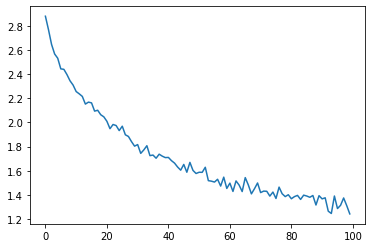

In [7]:
plot_loss(all_losses)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator


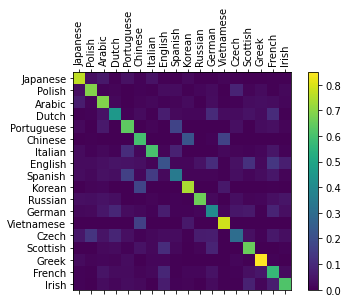

In [8]:
plot_confusion_matrix(categories, category_lines)

In [9]:
predict('Dovesky', categories)
predict('Jackson', categories)
predict('Satoshi', categories)


> Dovesky
(-0.61) Russian
(-1.27) Czech
(-2.83) English

> Jackson
(-0.39) Scottish
(-1.71) English
(-2.52) Russian

> Satoshi
(-1.41) Italian
(-1.47) Arabic
(-1.77) Japanese
